In [1]:
import csv
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
%matplotlib inline

In [3]:
log = pd.read_csv('data/driving_log.csv', nrows=10)
log.head()


,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0,0,0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0,0,0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0,0,0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0,0,0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0,0,0,1.418236


In [4]:
log = pd.read_csv('data/driving_log.csv', usecols=['center', 'left', 'right', 'steering'])
#log = log[log['steering']!=0].reset_index()
log.head()

,center,left,right,steering
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0


In [5]:
def normalize(image):
    return image/255 - 0.5

In [6]:
def process_show(num):
    image_pos = ['left', 'center', 'right'] 
    
    images = []
    
    print(log['steering'][num])
    
    
    for pos in image_pos:
        filename = 'data/'+log[pos][num].strip()
    
        images += [mpimg.imread(filename)]
        
        images += [cv2.flip(images[-1], 1)]

        #images += [cv2.cvtColor(images[0], cv2.COLOR_RGB2GRAY)]
    
        #images += [cv2.cvtColor(images[0], cv2.COLOR_RGB2YUV)[:,:,2]]
    
        images += [cv2.cvtColor(images[-1], cv2.COLOR_RGB2HSV)[:,:,1]]
    
      
        #low_threshold, high_threshold = 150, 255
        #images += [cv2.Canny(images[-1], low_threshold, high_threshold)]
    
        #images += [cv2.bitwise_or(images[-1], images[-2])]

    n_rows = len(image_pos)
    n_cols = len(images)//n_rows
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(17, 3*n_rows))
    axs = axs.ravel()
    
    i = 0
    for image in images:
        #image = normalize(image) 
        axs[i].imshow(image, cmap='gray')
        axs[i].set_title(image.shape)
        i+=1

0.05219137


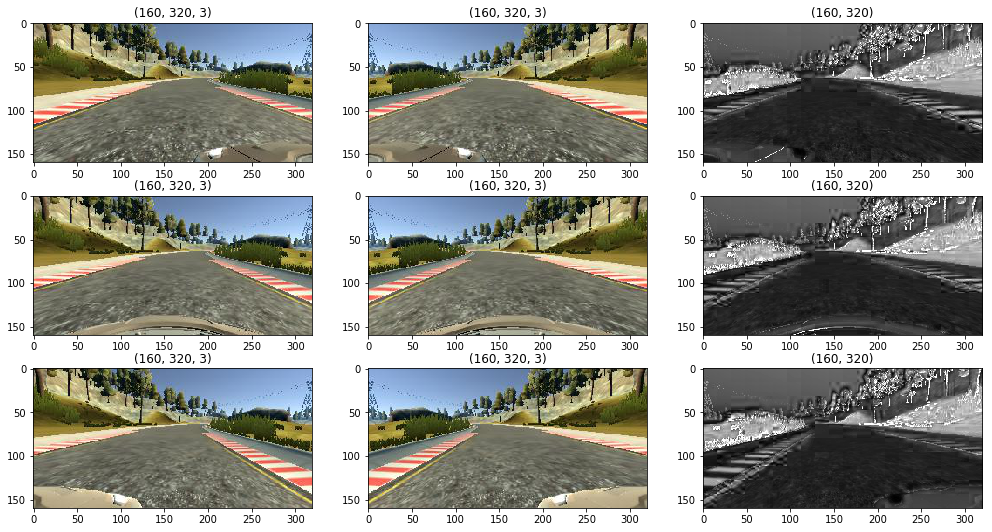

In [7]:
process_show(310)

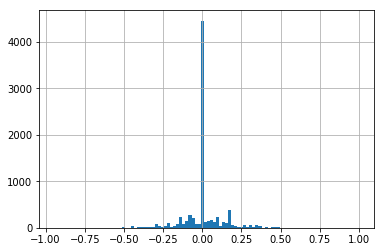

In [8]:
_ = log['steering'].hist(bins=100)

In [9]:
log['steering'].describe()

count    8036.000000
mean        0.004070
std         0.128840
min        -0.942695
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: steering, dtype: float64

In [10]:
def preprocess(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:,:,1]
    return image[:,:,None]

In [11]:
images = []

for i in range(len(log)):
    filename = 'data/'+log['center'][i].strip()
    
    image = mpimg.imread(filename)
    
    image = preprocess(image)
    
    images.append(image)
 
#plt.imshow(images[310])

In [12]:
measurements = list(log['steering'])

In [13]:
augmented_images, augmented_measurements = [], []

for image, measurement in zip(images, measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image, 1)[:,:,None])
    augmented_measurements.append(-measurement)    

In [14]:
X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)

In [15]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D

Using TensorFlow backend.


In [16]:
model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160,320,1)))
model.add(Cropping2D(cropping=((70,25), (0,0)), input_shape=(160,320,1)))
model.add(Flatten())
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=2)

model.save('model.h5')

Train on 12857 samples, validate on 3215 samples
Epoch 1/2
12857/12857 [==============================] - 7s - loss: 0.4324 - val_loss: 0.0255